In [41]:
import cv2
import imutils
import numpy as np
import pytesseract
from PIL import Image
from imutils import contours

### Para identificar placas usando OpenCV e Python, é necessário:

Converter a imagem para escala de cinza;
Aplicar a transformação morfológica Black Hat para revelar caracteres escuros contra fundos claros;
Realizar uma operação de fechamento para preencher gaps e áreas pequenas e identificar estruturas maiores;
Calcular o Gradiente de magnitude (eixo x), considerando a imagem da transformação Black Hat e colocar o resultado na escala [0, 255];
Suavizar a imagem, aplicar uma transformação de fechamento e outro threshold binário utilizando o método Otsu.

In [20]:
img = cv2.imread('CARRO2.JPG', cv2.IMREAD_UNCHANGED)

<img src="CARRO2.JPG">

In [33]:
# read original image
img = cv2.imread('CARRO2.jpg')
cv2.imshow('CARRO2', img)
cv2.waitKey(0)


# convert it to gray and apply filter 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to grey scale
gray = cv2.bilateralFilter(gray, 11, 17, 17)
cv2.imshow('gray', gray)
cv2.waitKey(0)

#apply treshold
thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_OTSU)[1]
cv2.imshow('thresh', thresh)
cv2.waitKey(0)

-1

In [34]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to grey scale
gray = cv2.bilateralFilter(gray, 11, 17, 17) #Blur to reduce noise
edged = cv2.Canny(gray, 30, 200) #Perform Edge detection

In [35]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

# Realizar uma operação de fechamento para preencher gaps e áreas pequenas
closing = cv2.morphologyEx(blackhat, cv2.MORPH_CLOSE, kernel)

# Calcular o Gradiente de magnitude (eixo x)
gradX = np.absolute(cv2.Sobel(closing, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1))
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")

# Suavizar a imagem
gradX = cv2.GaussianBlur(gradX, (5, 5), 0)

In [36]:
# Aplicar uma transformação de fechamento e outro threshold binário utilizando o método Otsu
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

In [37]:
# Encontrar os contornos na imagem thresholded
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

In [29]:
for c in cnts:
    # Computar a caixa delimitadora do contorno e usar a caixa delimitadora para calcular a proporção da altura e largura
    (x, y, w, h) = cv2.boundingRect(c)
    aspectRatio = w / float(h)

    # Computar a solidez do contorno original e a solidez do contorno convexo aproximado
    solidity = cv2.contourArea(c) / float(w * h)

    # Computar se o aspecto da largura e altura e solidez se enquadram nos critérios adequados
    keepAspectRatio = aspectRatio < 1.0
    keepSolidity = solidity > 0.15

    # Verificar se o contorno é grande o suficiente para ser considerado uma placa
    keepDims = w > 35 and h > 13

    # Garantir que o contorno passa por todos os nossos testes
    if keepAspectRatio and keepSolidity and keepDims:
        # Desenhar um retângulo ao redor do contorno na imagem original
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)

# Mostrar a imagem de saída
cv2.imshow("CARRO2", img)
cv2.waitKey(0)

-1

In [25]:
# Definir o caminho para o executável do Tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [26]:
image = Image.open('CARRO2.jpg')

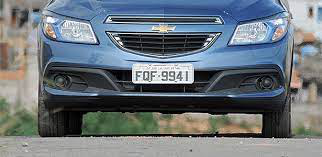

In [27]:
image

In [9]:
text = pytesseract.image_to_string('CARRO2.jpg')

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

In [21]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cnts = imutils.grab_contours(cnts)

cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]

screenCnt = None

In [22]:
#### loop over our contours

for c in cnts:

 #### approximate the contour

 peri = cv2.arcLength(c, True)

 approx = cv2.approxPolyDP(c, 0.018 * peri, True)

 

 # if our approximated contour has four points, then

 # we can assume that we have found our screen

 if len(approx) == 4:

  screenCnt = approx

  break


 


if screenCnt is None:

 detected = 0

 print ("No contour detected")

else:

 detected = 1


if detected == 1:

 cv2.drawContours(img, [screenCnt], -1, (0, 255, 0), 3)


# Masking the part other than the number plate

mask = np.zeros(gray.shape,np.uint8)

new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)

new_image = cv2.bitwise_and(img,img,mask=mask)


# Now crop

(x, y) = np.where(mask == 255)

(topx, topy) = (np.min(x), np.min(y))

(bottomx, bottomy) = (np.max(x), np.max(y))

Cropped = gray[topx:bottomx+1, topy:bottomy+1]


 


#Read the number plate

text = pytesseract.image_to_string(Cropped, config='--psm 11')

print("Detected Number is:",text)


cv2.imshow('image',img)

cv2.imshow('Cropped',Cropped)


cv2.waitKey(0)

cv2.destroyAllWindows()

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

array([[[16, 40, 28],
        [18, 42, 30],
        [20, 46, 33],
        ...,
        [25, 54, 38],
        [20, 48, 35],
        [20, 48, 35]],

       [[16, 40, 28],
        [15, 41, 28],
        [16, 42, 29],
        ...,
        [24, 53, 37],
        [19, 47, 34],
        [19, 47, 34]],

       [[16, 42, 28],
        [15, 41, 27],
        [14, 40, 26],
        ...,
        [21, 50, 34],
        [19, 45, 32],
        [19, 45, 32]],

       ...,

       [[34, 38, 43],
        [29, 33, 38],
        [25, 28, 32],
        ...,
        [10,  8,  8],
        [10,  8,  8],
        [10,  8,  8]],

       [[39, 43, 48],
        [33, 37, 42],
        [26, 29, 33],
        ...,
        [10,  8,  8],
        [10,  8,  8],
        [10,  8,  8]],

       [[44, 48, 53],
        [36, 40, 45],
        [28, 31, 35],
        ...,
        [10,  8,  8],
        [10,  8,  8],
        [10,  8,  8]]], dtype=uint8)

In [14]:
img = cv2.resize('img', (620,480) )
gray = cv2.cvtColor('img', cv2.COLOR_BGR2GRAY) #convert to grey scale





error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [8]:
gray = cv2.bilateralFilter(gray, 11, 17, 17)

NameError: name 'gray' is not defined

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to grey scale

gray = cv2.bilateralFilter(gray, 11, 17, 17) #Blur to reduce noise

edged = cv2.Canny(gray, 30, 200) #Perform Edge detection


#### find contours in the edged image, keep only the largest

#### ones, and initialize our screen contour

cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cnts = imutils.grab_contours(cnts)

cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]

screenCnt = None


#### loop over our contours

for c in cnts:

 #### approximate the contour

 peri = cv2.arcLength(c, True)

 approx = cv2.approxPolyDP(c, 0.018 * peri, True)

 

 # if our approximated contour has four points, then

 # we can assume that we have found our screen

 if len(approx) == 4:

  screenCnt = approx

  break


 


if screenCnt is None:

 detected = 0

 print "No contour detected"

else:

 detected = 1


if detected == 1:

 cv2.drawContours(img, [screenCnt], -1, (0, 255, 0), 3)


# Masking the part other than the number plate

mask = np.zeros(gray.shape,np.uint8)

new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)

new_image = cv2.bitwise_and(img,img,mask=mask)


# Now crop

(x, y) = np.where(mask == 255)

(topx, topy) = (np.min(x), np.min(y))

(bottomx, bottomy) = (np.max(x), np.max(y))

Cropped = gray[topx:bottomx+1, topy:bottomy+1]


 


#Read the number plate

text = pytesseract.image_to_string(Cropped, config='--psm 11')

print("Detected Number is:",text)


cv2.imshow('image',img)

cv2.imshow('Cropped',Cropped)


cv2.waitKey(0)

cv2.destroyAllWindows()

-1

In [9]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cnts = imutils.grab_contours(cnts)

cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]

screenCnt = None

NameError: name 'edged' is not defined

In [ ]:
from google.cloud import vision
import io

# Criar um cliente da API do Google Vision
client = vision.ImageAnnotatorClient()

# Carregar a imagem da placa
with io.open('placa.jpg', 'rb') as image_file:
    content = image_file.read()

image = vision.types.Image(content=content)

# Realizar a detecção de texto na imagem
response = client.text_detection(image=image)
texts = response.text_annotations

# Imprimir o texto detectado
for text in texts:
    print(text.description)